# Nuclear identification from spatial transcriptomic

the idea here is try to identificate nucleus in muscle section of mouse using gene expression information. The image was obtained using Visium HD tecnology with a maximum resolution of 8un.

In [96]:
#import library
import spatialdata as sd
import spatialdata_plot
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

In [3]:
#import the spatial transcriptomic data and create a spatialdata object
data_path = "/home/stefar/Documents/Spatial-Transcriptomic/data/blocco1_sham"
sdata = sd.read_zarr(data_path)
sdata

/tmp/ipykernel_7079/3989613102.py:3: UserWarning: SpatialData is not stored in the most current format. If you want to use Zarr v3, please write the store to a new location using `sdata.write()`.
  sdata = sd.read_zarr(data_path)
/home/stefar/Documents/Spatial-Transcriptomic/.venv/lib/python3.11/site-packages/zarr/core/group.py:3535: ZarrUserWarning: Object at zmetadata is not recognized as a component of a Zarr hierarchy.
  warnings.warn(


SpatialData object, with associated Zarr store: /home/stefar/Documents/Spatial-Transcriptomic/data/blocco1_sham
├── Images
│     ├── 'blocco1_hires_image': DataArray[cyx] (3, 1849, 4270)
│     ├── 'blocco1_lowres_image': DataArray[cyx] (3, 185, 427)
│     └── 'fluo_image': DataTree[cyx] (3, 7000, 16166), (3, 3500, 8083), (3, 1750, 4041), (3, 875, 2020)
├── Shapes
│     ├── 'GFP_poly': GeoDataFrame shape: (2, 5) (2D shapes)
│     ├── 'blocco1_square_008um': GeoDataFrame shape: (171116, 2) (2D shapes)
│     ├── 'blocco1_square_016um': GeoDataFrame shape: (44363, 1) (2D shapes)
│     ├── 'intissue_008um': GeoDataFrame shape: (95232, 3) (2D shapes)
│     └── 'intissue_poly': GeoDataFrame shape: (1, 5) (2D shapes)
└── Tables
      ├── 'filtered': AnnData (95232, 32285)
      ├── 'final_table': AnnData (95514, 32285)
      ├── 'square_008um': AnnData (95514, 32285)
      └── 'square_016um': AnnData (44363, 32285)
with coordinate systems:
    ▸ 'blocco1', with elements:
        blocco1_hires_

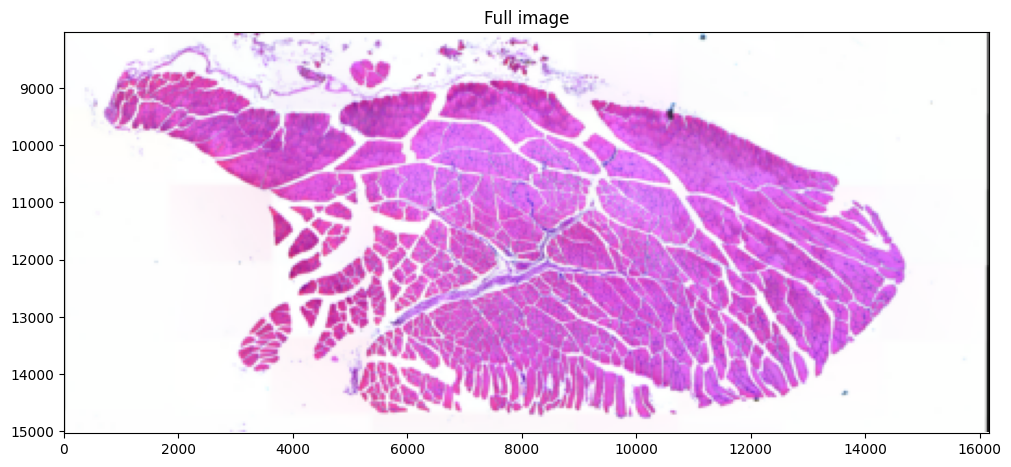

In [4]:
#plot the full image of muscle section
sdata.pl.render_images("blocco1_lowres_image").pl.show(coordinate_systems = "blocco1", title="Full image", figsize=(10,10))


In [4]:

#create a crop of the image in order to either reduce computational demand and also concentrate in a small portion 
#of the image for easier visualization of the bins during the analysis
min_x, min_y = 8000, 13000
max_x, max_y = 9000, 14000

sdata_cropped = sdata.query.bounding_box(
    min_coordinate=[min_x, min_y],
    max_coordinate=[max_x, max_y],
    axes=("x","y"),
    target_coordinate_system='blocco1',
    filter_table=True
)

In [5]:
sdata_cropped

SpatialData object
├── Images
│     ├── 'blocco1_hires_image': DataArray[cyx] (3, 265, 264)
│     ├── 'blocco1_lowres_image': DataArray[cyx] (3, 27, 27)
│     └── 'fluo_image': DataTree[cyx] (3, 1000, 1000), (3, 500, 500), (3, 250, 250), (3, 125, 125)
├── Shapes
│     ├── 'blocco1_square_008um': GeoDataFrame shape: (1640, 2) (2D shapes)
│     ├── 'blocco1_square_016um': GeoDataFrame shape: (436, 1) (2D shapes)
│     ├── 'intissue_008um': GeoDataFrame shape: (1640, 3) (2D shapes)
│     └── 'intissue_poly': GeoDataFrame shape: (1, 5) (2D shapes)
└── Tables
      ├── 'filtered': AnnData (1640, 32285)
      ├── 'final_table': AnnData (1640, 32285)
      ├── 'square_008um': AnnData (1640, 32285)
      └── 'square_016um': AnnData (436, 32285)
with coordinate systems:
    ▸ 'blocco1', with elements:
        blocco1_hires_image (Images), blocco1_lowres_image (Images), fluo_image (Images), blocco1_square_008um (Shapes), blocco1_square_016um (Shapes), intissue_008um (Shapes), intissue_poly (Shap

## Nuclei identification
Through the use of the marker now the idea is to see where we expect the presence of a nuclei this is also confirmed by the expression information

In [6]:
adata = sdata_cropped["square_008um"]

### MTJ myonuclei

In [91]:
MTJ_myonuclei = ["Ankrd1", "Ankrd1",
"Col22a1",
"Slc24a2",
"Adamts20",
"Itgb1",
"Col24a1",
"Col1a2",
"Col6a1",
"Col6a3",
]


In [92]:
marker_quantification = {}
for marker in NMJ_myonuclei:
    if marker in adata.var_names:
        marker_quantification[marker] = adata[:, marker].X.sum(axis=0)

marker_quantification

{'Ttn': matrix([[3639.]], dtype=float32),
 'Ache': matrix([[16.]], dtype=float32)}

In [81]:
#add a column representing a type of nucleo, for each row sum all the column correponding to the given marker
adata.obs["MTJ_myonuclei"]= adata[:, MTJ_myonuclei].X.sum(axis=1)

In [94]:
adata[:, MTJ_myonuclei].X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 89 stored elements and shape (1640, 10)>

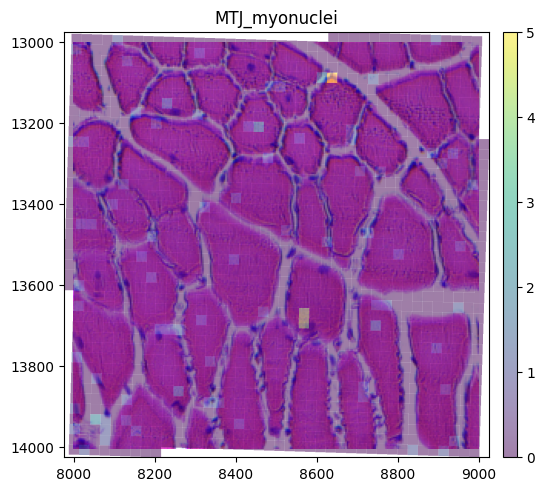

In [113]:
#colored bins cover all the image, so i try to use transparent bins
sdata_cropped.pl.render_images("blocco1_hires_image") \
    .pl.render_shapes(
        "intissue_008um", 
        "MTJ_myonuclei", 
        fill_alpha=0.5,   # Prova un valore molto basso come 0.2 o 0.3
        outline=True,     # Togliamo il bordo per ora, così non "sporca" l'immagine
    ).pl.show(coordinate_systems="blocco1", title = "MTJ_myonuclei")

### NMJ myonuclei
here the approach is different since a nuclei is considered a NMJ_myonuclei only if there is a combined presence of the markers: Ttn + Ache.
Furthermore a bin is considered associated to a NMJ_myonuclei if it have at least one expression combination of the markers. In this case there are 4 possible marker combination associated to NMJ_myonuclei.

In [119]:
#define the markers
NMJ_myonuclei = [["Ttn" , "Ache"],
                 ["Ttn" , "Etv5"],
                 ["Ttn" ,"Ano4"],
                 ["Ttn" ,"Chrne"]]


In [122]:
for marker in NMJ_myonuclei:
    print(marker)

['Ttn', 'Ache']
['Ttn', 'Etv5']
['Ttn', 'Ano4']
['Ttn', 'Chrne']


In [124]:
expr_arrays = {}
counter = 0
for marker in NMJ_myonuclei:
    counter += 1
    expr_matrix = adata[:, marker].X.toarray()
    all_present = np.all(expr_matrix > 0, axis=1)  # Boolean array
    sum_expr = expr_matrix.sum(axis=1)
    sum_expr[all_present==False] = 0

    expr_arrays[counter] = sum_expr

In [139]:
final_array = expr_arrays[1] + expr_arrays[2] + expr_arrays[3] + expr_arrays[4]


In [140]:
final_array

array([0., 0., 0., ..., 0., 0., 0.], shape=(1640,), dtype=float32)

In [141]:
#add a column to adata 
adata.obs["NMJ_myonuclei"] = final_array

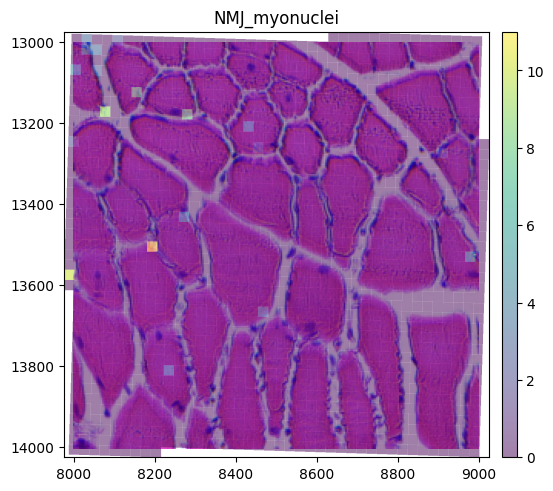

In [142]:
#plot the bins associated to selected markers
#colored bins cover all the image, so i try to use transparent bins
sdata_cropped.pl.render_images("blocco1_hires_image") \
    .pl.render_shapes(
        "intissue_008um", 
        "NMJ_myonuclei", 
        fill_alpha=0.5,   # Prova un valore molto basso come 0.2 o 0.3
        outline=True,     # Togliamo il bordo per ora, così non "sporca" l'immagine
    ).pl.show(coordinate_systems="blocco1", title="NMJ_myonuclei")